# ALGORITMOS BASADOS EN SERIES TEMPORALES

## 4) Modelo de Media Movil Exponencial Ponderada (EWMA) - SUAVIZADO EXPONENCIAL

El suavizado exponencial se refiere al uso de una media móvil ponderada exponencialmente (EWMA) para "suavizar" una serie temporal. 
El objetivo es identificar los 3 componentes de las series temporales.

### Estacionariedad, Tendencia y Estacionalidad

* **ESTACIONARIEDAD:** propiedad de una serie temporal donde sus características estadísticas, como la media, la varianza y la autocorrelación, permanecen constantes a lo largo del tiempo
   * **Serían las propiedades de la serie que no varían con respecto al tiempo.**
    
* **TENDENCIA:** cambio gradual ascendente o descendente en el nivel de la serie o la trayectoria que siguen los valores de la serie de aumentar o disminuir a lo largo del tiempo
    * **Sería las forma de como la serie evoluciona a lo largo del tiempo.**

* **ESTACIONALIDAD:** Consiste en subidas y bajadas periódicas que se presentan en forma regular en la serie de tiempo
   * **Sería las variaciones que se producen periodica o ciclicamente a lo largo del año.**
    

### EWMA

El suavizado exponencial simple (método Brown) se define por la relación:

\begin{equation}
S_t = \alpha X_t + (1-\alpha) S_{t-1} \quad \text{donde} \quad \alpha \in (0,1)
\end{equation}

o equivalentemente:

\begin{equation}
S_t = S_{t-1} + \alpha (X_t - S_{t-1})
\end{equation}

Algunas observaciones en torno a esa definición:
* la serie suavizada es un promedio ponderado simple del pasado y el presente
* interpretación del factor de suavizado $\alpha$: actualidad vs suavizado (ver más abajo). Define cuán rápido "olvidaremos" la última observación verdadera disponible.
* $\alpha$ se selecciona sobre la base del juicio de expertos o se estima (con MSE); statsmodels realiza la estimación de forma predeterminada
* por su propia naturaleza, el suavizado necesita algo de tiempo para ponerse al día con la dinámica de su serie temporal. Una regla general para un tamaño de muestra razonable es que necesita $\frac{3}{\alpha}$ observaciones.
* La exponencialidad está oculta en la recursividad de la función: multiplicamos por $(1−\alpha)$ cada vez, lo que ya contiene una multiplicación por el mismo factor de los valores del modelo anterior.
* el método es adecuado para pronosticar datos sin una tendencia clara o un patrón estacional

Con la configuración de la ecuación anterior, tenemos la siguiente forma de un pronóstico a largo plazo:
\begin{equation}
\hat{X}_{t+h} = S_t
\end{equation}


In [1]:
import itertools
from datetime import datetime
import pandas as pd
import numpy as np
import statsmodels.api as sm
from random import gauss
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from random import random
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing, Holt

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 

# Mostrar el DataFrame resultante
import ace_tools_open as tools

# Evitar Mensajes Molestos
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category= FutureWarning)

In [2]:
# ELEGIR el PROVEEDOR

proveedor = 20
label = '20_Molinos'

# Se puede leer direto de la BD de SQL o desde un archivo CSV local previamente

# Cargar Datos
data = pd.read_csv(f'data/{label}.csv')
data.head()

# Adecuar Tipos de Datos
data['Sucursal']= data['Sucursal'].astype(int)
data['Familia']= data['Familia'].astype(int)
data['Rubro']= data['Rubro'].astype(int)
data['SubRubro']= data['SubRubro'].astype(int)
data['Clasificacion']= data['Clasificacion'].astype(int)
data['Codigo_Articulo']= data['Codigo_Articulo'].astype(int)
data['Fecha'] = pd.to_datetime(data['Fecha'])  # Convertir a formato datetime si aún no lo está
data.sort_values(by='Fecha', ascending=True)  # Ordenar por fecha de menor a mayor

# Crear una nueva columna con el mes y el año para análisis temporal
data['Año-Mes'] = data['Fecha'].dt.to_period('M')

# Crear una nueva columna con el formato Año-Semana (AAAA-WW) a partir de la columna Fecha
data['Año-Semana'] = data['Fecha'].dt.strftime('%Y-%W')

# Confirmar que la columna sigue siendo un campo datetime
#print(data.dtypes)

#data = data.sort_values(by='Fecha', ascending=True)  # Ordenar en orden ascendente (del más antiguo al más reciente)
#data = data.reset_index()

# Recortar Cantidad de Datos ULTIMO AÑO COMPLETO
df = data[data['Fecha']>='2023-01-01']

In [ ]:
# Seleccionar un código de artículo y sucursal que tengan datos
codigo_articulo = df['Codigo_Articulo'].value_counts().idxmax()
sucursal = df['Sucursal'].value_counts().idxmax()


# Filtrar el DataFrame

df_filtrado = df[
    (df['Codigo_Articulo'] == codigo_articulo) &
    (df['Sucursal'] == sucursal)
]

# Verificar si la combinación seleccionada tiene datos
if df_filtrado.empty:
    raise ValueError("No hay datos para la combinación seleccionada. Cambia los valores de 'codigo_articulo' y 'sucursal'.")

# Convertir nuevamente las columnas a int32 después de la conversión - No me va a agarrar de Nuevo !!!!!
df_filtrado['Codigo_Articulo'] = df_filtrado['Codigo_Articulo'].astype('int32')
df_filtrado['Sucursal'] = df_filtrado['Sucursal'].astype('int32')

# Eliminar Columnas Innecesarias
df_filtrado = df_filtrado[['Fecha', 'Unidades']]

# Convertir en serie temporal con 'Año-Mes' como índice
df_filtrado.set_index('Fecha', inplace=True)

# Verificar después de la transformación
tools.display_dataframe_to_user(name="SET de Datos del Proveedor", dataframe=df_filtrado)
df_filtrado.info()

In [5]:
# general settings
class CFG:
    data_folder = '../data/'
    img_dim1 = 20
    img_dim2 = 10
        
# adjust the parameters for displayed figures    
plt.rcParams.update({'figure.figsize': (CFG.img_dim1,CFG.img_dim2)})   

In [12]:
df_filtrado = df_filtrado[df_filtrado.index>='2024-02-01']

In [ ]:
for alpha_sm in [0.2 , 0.5, 0.9]:

    df_filtrado.plot.line()
    fit1 = SimpleExpSmoothing(df_filtrado).fit(smoothing_level = alpha_sm  ,optimized=False)
    fcast1 = fit1.forecast(12).rename('alpha = ' + str(alpha_sm))
    fcast1.plot(marker='o', color='red', legend=True)
    fit1.fittedvalues.plot(  color='red')
    plt.show()

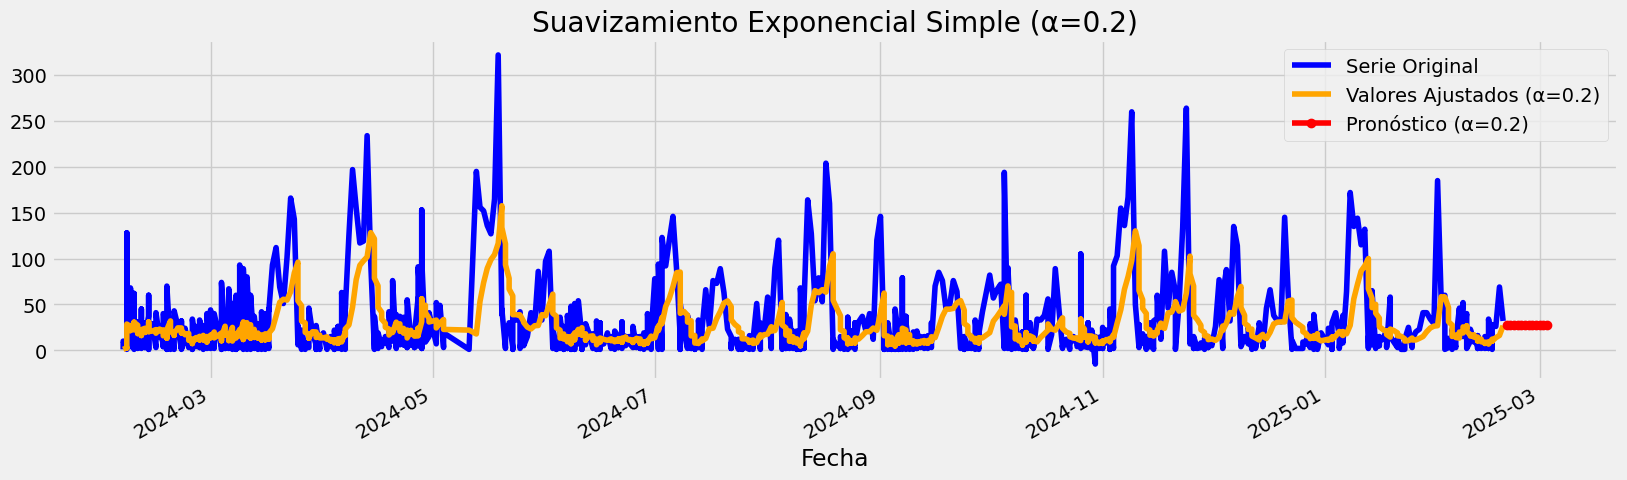

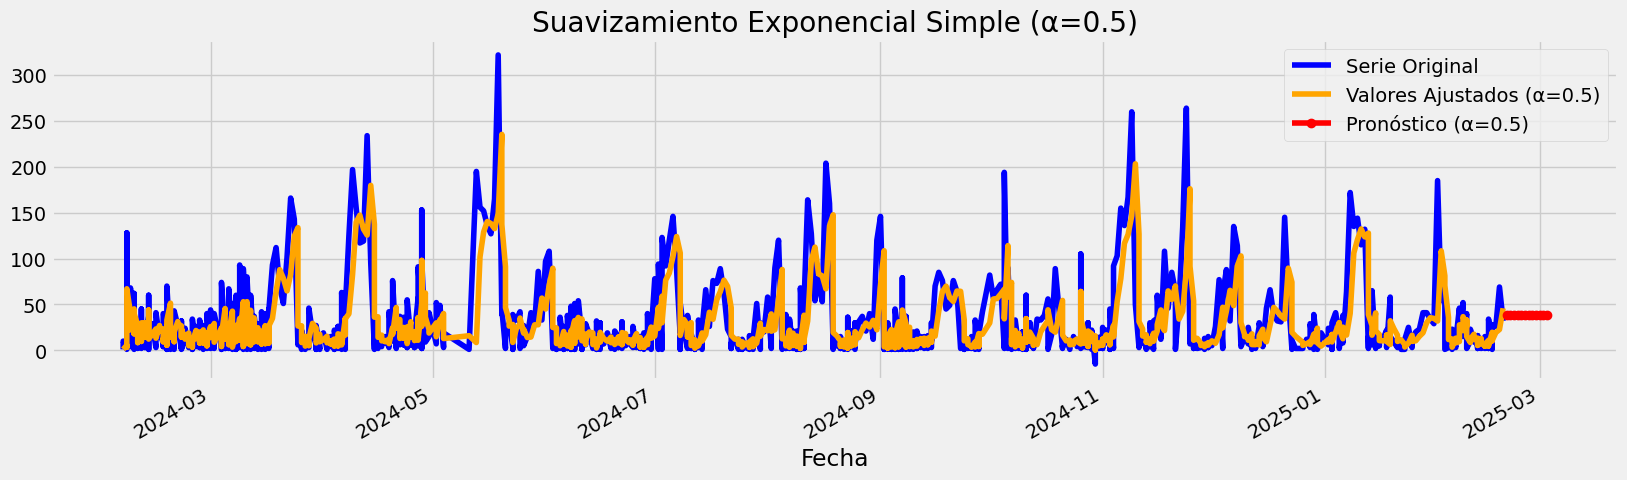

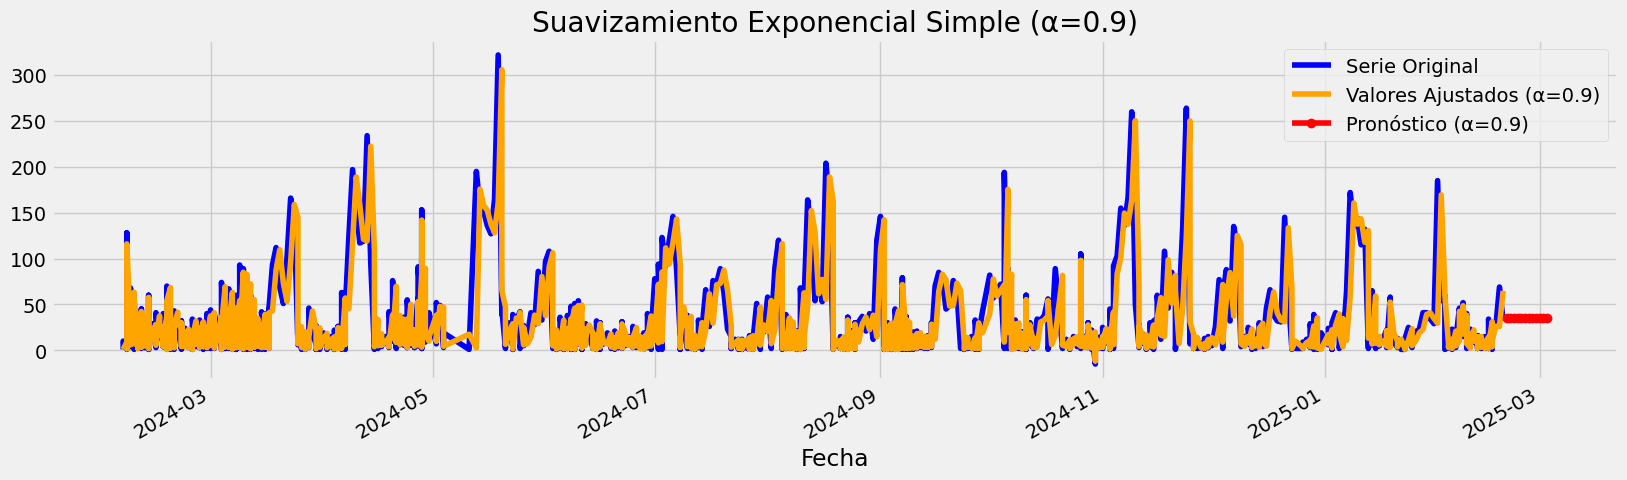

In [ ]:
# Convertir df en una Serie unidimensional
df_series = df_filtrado.squeeze().astype(float)

# Definir el último índice del DataFrame como la fecha final
last_date = df_series.index[-1]  # Última fecha del DataFrame

# Bucle para probar diferentes valores de alpha
for alpha_sm in [0.2, 0.5, 0.9]:
    plt.figure(figsize=(18, 5))

    # Graficar la serie original
    df_series.plot.line(label="Serie Original", color="blue")

    # Aplicar suavizamiento exponencial simple
    fit1 = SimpleExpSmoothing(df_series).fit(smoothing_level=alpha_sm, optimized=False)

    # Generar la predicción para los próximos 12 períodos
    fcast1 = fit1.forecast(12).rename(f'alpha = {alpha_sm}')
    
    # Corregir el índice de fechas para que siga a `df_series`
    fcast1.index = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=12, freq='D')

    # Graficar valores ajustados
    fit1.fittedvalues.plot(color='orange', label=f"Valores Ajustados (α={alpha_sm})")

    # Graficar la predicción corregida
    fcast1.plot(marker='o', color='red', legend=True, label=f"Pronóstico (α={alpha_sm})")

    plt.title(f"Suavizamiento Exponencial Simple (α={alpha_sm})")
    plt.legend()
    plt.show()

## Suavizado exponencial doble

El suavizado exponencial doble es similar a tomar un componente más en la descomposición estacional: comenzamos solo con el NIVEL y también tenemos en cuenta la TENDENCIA. Asumiendo que la dirección futura de los cambios de la serie temporal depende de los cambios ponderados anteriores. El suavizado exponencial doble, también conocido como método **Holt**, se define mediante la relación:

\begin{equation}
S_t = \alpha X_t + (1 - \alpha) (S_{t-1} + b_{t-1})\\
b_t = \beta (S_t - S_{t-1}) + (1- \beta) b_{t-1}
\end{equation}

donde $S_1 = X_1$, $\quad b_1 = X_1 - X_0$ y $\alpha, \beta \in (0,1)$

La primera ecuación describe la intersección, que depende del valor actual de la serie. El segundo término ahora se divide en valores anteriores del nivel y de la tendencia. La segunda función describe la tendencia, que depende de los cambios de nivel en el paso actual y del valor anterior de la tendencia. La predicción completa se compone de la suma del nivel y la tendencia, y la diferencia con el suavizado exponencial simple es que necesitamos un segundo parámetro para suavizar la tendencia; como antes, estos pueden establecerse en función del juicio de expertos o estimarse (conjuntamente) a partir de los datos.

El pronóstico $h$ de pasos por delante (PREDICCIÓN) se define mediante
\begin{equation}
\hat{X}_{t+h} = S_t + h b_t
\end{equation}

La función de pronóstico ya no es plana, sino que muestra una tendencia: el pronóstico de $h$ pasos por delante es igual al último nivel estimado más $h$ multiplicado por el último valor de tendencia estimado.


#### 📌 OJO PARA CAPTURAR ESTACIONALIDAD hay que procesar 2 años completos de datos.

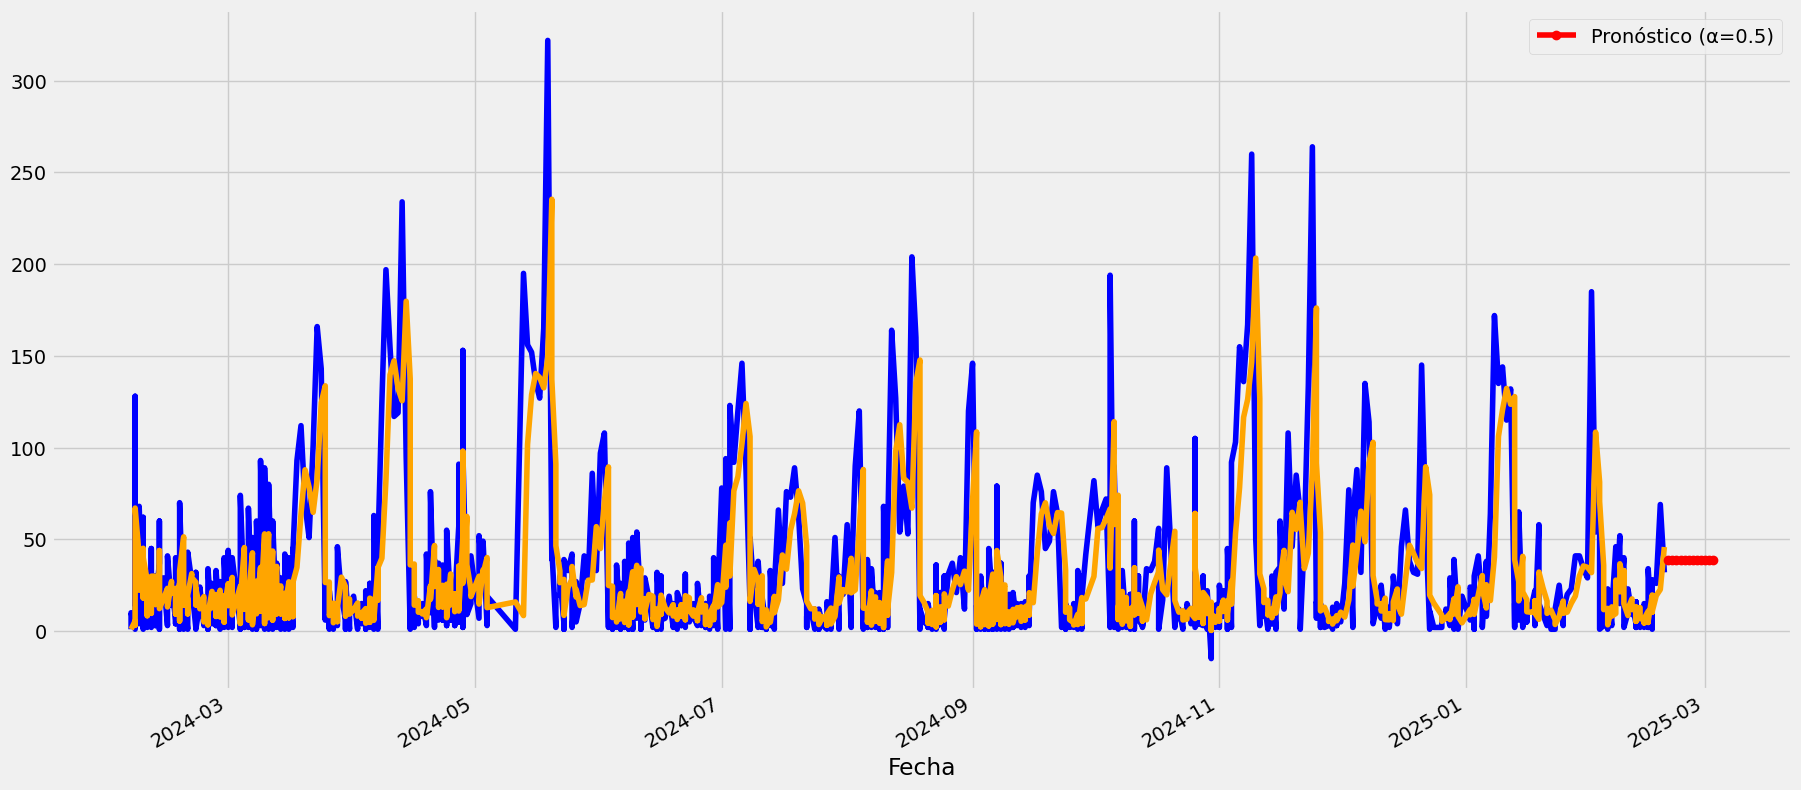

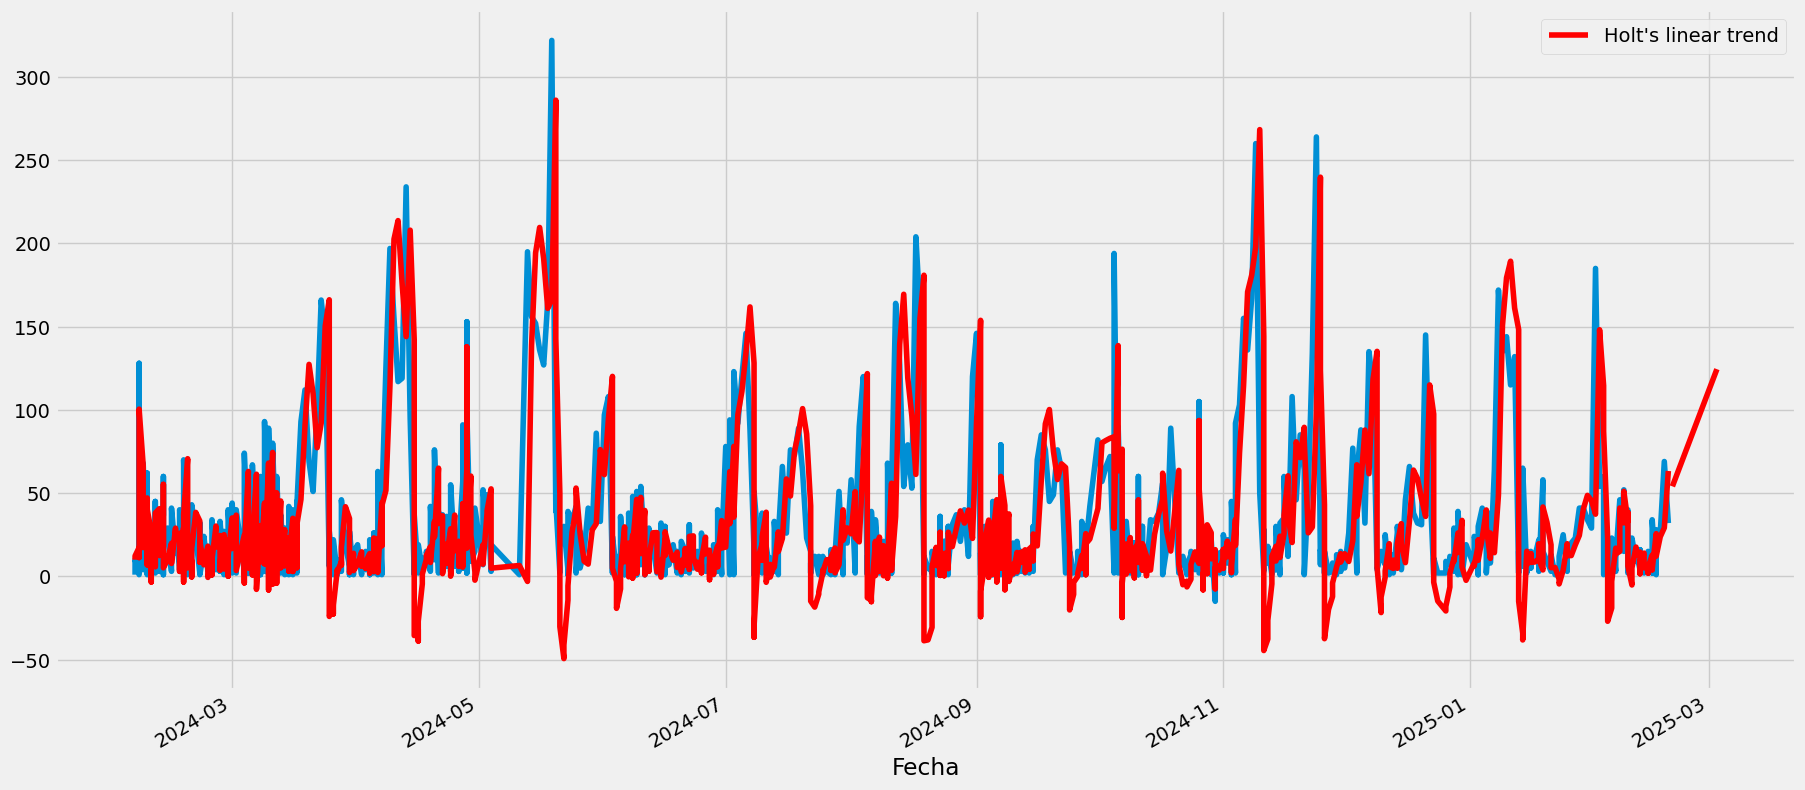

In [26]:
# Convertir df en una Serie unidimensional
df_series = df_filtrado.squeeze().astype(float)

# Definir el último índice del DataFrame como la fecha final
last_date = df_series.index[-1]  # Última fecha del DataFrame

alpha_sm = 0.5   # Parámetro de Ajuste

# Graficar la serie original
df_series.plot.line(label="Serie Original", color="blue")

# Aplicar suavizamiento exponencial simple
fit1 = SimpleExpSmoothing(df_series).fit(smoothing_level=alpha_sm, optimized=False)

# Generar la predicción para los próximos 12 períodos
fcast1 = fit1.forecast(12).rename(f'alpha = {alpha_sm}')

# Corregir el índice de fechas para que siga a `df_series`
fcast1.index = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=12, freq='D')

# Graficar valores ajustados
fit1.fittedvalues.plot(color='orange', label=f"Valores Ajustados (α={alpha_sm})")

# Graficar la predicción corregida
fcast1.plot(marker='o', color='red', legend=True, label=f"Pronóstico (α={alpha_sm})")

plt.show()


## Segundo Gráfico
df_series.plot.line()
fit1 = Holt(df_series).fit(smoothing_level=0.5, smoothing_slope=0.5, optimized=False)
fcast1 = fit1.forecast(12).rename("Holt's linear trend")
# Corregir el índice de fechas para que siga a `df_series`
fcast1.index = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=12, freq='D')
fit1.fittedvalues.plot(color='red')
fcast1.plot(color='red', legend=True)
plt.show()

### 1) RUTINA PRINCIPAL

In [1]:
# Importar Librerias
import pandas as pd
import numpy as np
from datetime import datetime
# Mostrar los resultados
import ace_tools_open as tools
# Mostrar el DataFrame resultante
import ace_tools_open as tools

# Evitar Mensajes Molestos
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

In [4]:
# ELEGIR el PROVEEDOR

proveedor = 20
label = '20_Molinos'

# Se puede leer direto de la BD de SQL o desde un archivo CSV local previamente

# Cargar Datos
data = pd.read_csv(f'data/{label}.csv')
data.head()

# Adecuar Tipos de Datos
data['Sucursal']= data['Sucursal'].astype(int)
data['Codigo_Articulo']= data['Codigo_Articulo'].astype(int)
data['Sucursal']= data['Sucursal'].astype(int)
data['Fecha'] = pd.to_datetime(data['Fecha'])  # Convertir a formato datetime si aún no lo está
data.sort_values(by='Fecha', ascending=True)  # Ordenar por fecha de menor a mayor

# Crear una nueva columna con el mes y el año para análisis temporal
#data['Año-Mes'] = data['Fecha'].dt.to_period('M')

# Crear una nueva columna con el formato Año-Semana (AAAA-WW) a partir de la columna Fecha
#data['Año-Semana'] = data['Fecha'].dt.strftime('%Y-%W')

# Confirmar que la columna sigue siendo un campo datetime
#print(data.dtypes)

#data = data.sort_values(by='Fecha', ascending=True)  # Ordenar en orden ascendente (del más antiguo al más reciente)
#data = data.reset_index()

# Recortar Cantidad de Datos ULTIMO AÑO COMPLETO
df = data[data['Fecha']>='2021-01-01']

In [7]:
import pandas as pd

# Configurar la ventana de pronóstico (por ejemplo, 30 o 45 días)
forecast_window = 30  # Puedes cambiarlo a 45 según tus necesidades

# Parámetro de suavizado (alpha); valores cercanos a 1 dan más peso a los datos recientes
alpha = 0.3

# Lista para almacenar los resultados del forecast
resultados = []

# Agrupar los datos por 'Codigo_Articulo' y 'Sucursal'
for (codigo, sucursal), grupo in df.groupby(['Codigo_Articulo', 'Sucursal']):
    # Ordenar cronológicamente y fijar 'Fecha' como índice
    grupo = grupo.set_index('Fecha').sort_index()
    
    # Resamplear a frecuencia diaria sumando las ventas y rellenando días sin datos
    ventas_diarias = grupo['Unidades'].resample('D').sum().fillna(0)
    
    # Calcular el suavizado exponencial (EWMA) sobre la serie de ventas diarias
    ewma_series = ventas_diarias.ewm(alpha=alpha, adjust=False).mean()
    
    # Tomamos el último valor suavizado como forecast diario
    ultimo_ewma = ewma_series.iloc[-1]
    
    # El pronóstico total para la ventana definida es el pronóstico diario multiplicado por la cantidad de días
    forecast_total = ultimo_ewma * forecast_window
    
    resultados.append({
        'Codigo_Articulo': codigo,
        'Sucursal': sucursal,
        'Forecast': round(forecast_total, 2),
        'EWMA': round(ultimo_ewma, 3)
    })

# Crear el DataFrame final con los resultados
df_forecast = pd.DataFrame(resultados)

# Mostrar una parte del resultado
print(df_forecast.head())


   Codigo_Articulo  Sucursal  Forecast   EWMA
0              166         1     18.20  0.607
1              166         2     61.08  2.036
2              166         3    150.01  5.000
3              166         5     25.88  0.863
4              166         7     20.18  0.673


In [6]:
# Verificar después de la transformación
tools.display_dataframe_to_user(name="SET de Datos del Proveedor", dataframe=df_forecast)
df_forecast.info()

SET de Datos del Proveedor


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4558 entries, 0 to 4557
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Codigo_Articulo   4558 non-null   int32  
 1   Sucursal          4558 non-null   int32  
 2   Demanda_esperada  4558 non-null   float64
dtypes: float64(1), int32(2)
memory usage: 71.3 KB


### Detalles del Enfoque
1) Conversión y Resampleo:
Se transforma la columna Fecha a tipo datetime y se agrupa la información diaria por artículo y sucursal, resampleando para obtener una serie de ventas diarias (rellenando con 0 los días sin ventas).

2) Cálculo del EWMA:
Usando ewm(alpha=0.3, adjust=False).mean(), se calcula el suavizado exponencial. El parámetro alpha controla cuánto peso se le da a los datos recientes (un valor mayor da más peso a los días recientes).

3) Forecast para la Ventana:
Se utiliza el último valor suavizado como pronóstico diario y se multiplica por la cantidad de días de la ventana (por ejemplo, 30 días) para obtener la demanda total esperada en ese período.

#### Escalabilidad:
* El proceso se realiza para cada combinación de artículo y sucursal, generando un DataFrame final (df_forecast) que contiene la demanda esperada consolidada por cada uno.

#### Consideraciones
* Ajuste del Parámetro:
- Puedes experimentar con diferentes valores de alpha para ver cuál se adapta mejor a la dinámica de tus ventas.

#### Modelos Más Complejos:
* Si tus series presentan tendencias o estacionalidades, podrías considerar modelos de suavizado exponencial más avanzados, como el método Holt o Holt-Winters, disponibles en la librería statsmodels.

* Este enfoque te ofrece una base sencilla y escalable para comenzar a pronosticar la demanda utilizando EWMA. Luego, podrías ir evaluando y comparando su desempeño para ajustarlo o considerar modelos más sofisticados según sea necesario

In [9]:
import pandas as pd
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings

# Para evitar warnings innecesarios en el ajuste de modelos
warnings.filterwarnings("ignore")

# Configurar la ventana de pronóstico (por ejemplo, 30 días o 45 días)
forecast_window = 30  # Cambia a 45 si es necesario

# Lista para almacenar los resultados del forecast
resultados = []

# Agrupar los datos por 'Codigo_Articulo' y 'Sucursal'
for (codigo, sucursal), grupo in df.groupby(['Codigo_Articulo', 'Sucursal']):
    # Ordenar cronológicamente y establecer 'Fecha' como índice
    grupo = grupo.set_index('Fecha').sort_index()
    
    # Resamplear a frecuencia diaria, sumando las ventas y rellenando con 0 los días sin datos
    ventas_diarias = grupo['Unidades'].resample('D').sum().fillna(0)
    
    # Verificar que la serie tenga suficientes datos para ajustar el modelo
    if len(ventas_diarias) < 2 * 7:  # por ejemplo, al menos dos ciclos de la estacionalidad semanal
        continue

    try:
        # Ajustar el modelo Holt-Winters: 
        # - trend: 'add' para tendencia aditiva
        # - seasonal: 'add' para estacionalidad aditiva
        # - seasonal_periods: 7 (para estacionalidad semanal)
        modelo = ExponentialSmoothing(ventas_diarias, trend='add', seasonal='add', seasonal_periods=7)
        modelo_ajustado = modelo.fit(optimized=True)
        
        # Realizar el forecast para la ventana definida
        pronostico = modelo_ajustado.forecast(forecast_window)
        
        # La demanda esperada es la suma de las predicciones diarias en el periodo
        forecast_total = pronostico.sum()
    except Exception as e:
        # Si ocurre algún error en el ajuste, puedes asignar un valor nulo o manejarlo de otra forma
        forecast_total = None
    
    resultados.append({
        'Codigo_Articulo': codigo,
        'Sucursal': sucursal,
        'Demanda_esperada': round(forecast_total, 2) if forecast_total is not None else None
    })

# Crear el DataFrame final con los resultados del forecast
df_forecast = pd.DataFrame(resultados)


   Codigo_Articulo  Sucursal  Demanda_esperada
0              166         1             13.05
1              166         2             69.69
2              166         3             75.39
3              166         5              7.11
4              166         7              5.30


In [10]:
# Verificar después de la transformación
tools.display_dataframe_to_user(name="SET de Datos del Proveedor", dataframe=df_forecast)
df_forecast.info()

SET de Datos del Proveedor


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4393 entries, 0 to 4392
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Codigo_Articulo   4393 non-null   int32  
 1   Sucursal          4393 non-null   int32  
 2   Demanda_esperada  4393 non-null   float64
dtypes: float64(1), int32(2)
memory usage: 68.8 KB


### 2) PRUEBA con DATOS

In [30]:
# DEJAR solo las columnas Útiles

# Eliminar Columnas Innecesarias
df_prv = df[['Fecha', 'Codigo_Articulo', 'Sucursal', 'Unidades']]

# Convertir en serie temporal con 'Año-Mes' como índice
# df_prv.set_index('Fecha', inplace=True)

# Verificar después de la transformación
tools.display_dataframe_to_user(name="SET de Datos del Proveedor", dataframe=df_prv)
df_prv.info()





SET de Datos del Proveedor


<class 'pandas.core.frame.DataFrame'>
Index: 1666158 entries, 755 to 2400939
Data columns (total 4 columns):
 #   Column           Non-Null Count    Dtype         
---  ------           --------------    -----         
 0   Fecha            1666158 non-null  datetime64[ns]
 1   Codigo_Articulo  1666158 non-null  int32         
 2   Sucursal         1666158 non-null  int32         
 3   Unidades         1666158 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int32(2)
memory usage: 50.8 MB


In [31]:
# Mostrar los resultados
# import ace_tools_open as tools
tools.display_dataframe_to_user(name="SET de Datos del Proveedor", dataframe=df)

SET de Datos del Proveedor


In [35]:
# Calcular la demanda estimada utilizando el algoritmo básico
forecast_result = get_forecast(df, algorithm='basic',current_date='2024-01-01', period_length=15)


# Eliminar del Forecast los productos que no se hayan vendido en las últimas 2 ventantas
# eliminar si ventas_last y ventas_previous son 0
forecast_result = forecast_result[~((forecast_result['ventas_last'] == 0) & (forecast_result['ventas_previous'] == 0))]

#El operador ~ invierte la condición, seleccionando las filas que no cumplen la condición (es decir, que tienen al menos un valor diferente de 0 en esas columnas).


# Mostrar los resultados
# import ace_tools_open as tools
tools.display_dataframe_to_user(name="Demanda estimada utilizando el algoritmo básico:", dataframe=forecast_result)

Demanda estimada utilizando el algoritmo básico:


### 3) BACK TESTING  

* Generamos 4 períodos sobre la base histórica.
* Simulamos la fecha actual dentro del período de Datos.
* Comparamos contra FORECAST contra ACTUAL que sería el Real
* Graficamos


In [36]:
current_date ='2024-01-15'   # Establecemos un Curernt Date dentro del Rango de Datos
period_length=15

current_date =  pd.to_datetime(current_date)

# Definir rangos de fechas para cada período
last_period_start = current_date - pd.Timedelta(days=period_length - 1)
last_period_end = current_date

previous_period_start = current_date - pd.Timedelta(days=2 * period_length - 1)
previous_period_end = current_date - pd.Timedelta(days=period_length)

same_period_last_year_start = current_date - pd.DateOffset(years=1) - pd.Timedelta(days=period_length - 1)
same_period_last_year_end = current_date - pd.DateOffset(years=1)

actual_period_start = current_date + pd.Timedelta(+ 1)
actual_period_end = current_date + pd.Timedelta(days=period_length + 2)

In [37]:
# CALCULAMOS LA DEMANDA y la SIMULACIÓN

# Facctores de Pnderación
# Cada uno de los 3 períodos
factor_last = 70
factor_previous = 20
factor_year = 10

 # Filtrar los datos para cada uno de los períodos
df_last = df[(df['Fecha'] >= last_period_start) & (df['Fecha'] <= last_period_end)]
df_previous = df[(df['Fecha'] >= previous_period_start) & (df['Fecha'] <= previous_period_end)]
df_same_year = df[(df['Fecha'] >= same_period_last_year_start) & (df['Fecha'] <= same_period_last_year_end)]
df_actual = df[(df['Fecha'] >= actual_period_start) & (df['Fecha'] <= actual_period_end)]

# Agregar las ventas (unidades) por artículo y sucursal para cada período
sales_last = df_last.groupby(['Codigo_Articulo', 'Sucursal'])['Unidades'] \
                  .sum().reset_index().rename(columns={'Unidades': 'ventas_last'})
sales_previous = df_previous.groupby(['Codigo_Articulo', 'Sucursal'])['Unidades'] \
                           .sum().reset_index().rename(columns={'Unidades': 'ventas_previous'})
sales_same_year = df_same_year.groupby(['Codigo_Articulo', 'Sucursal'])['Unidades'] \
                              .sum().reset_index().rename(columns={'Unidades': 'ventas_same_year'})
sales_actual = df_actual.groupby(['Codigo_Articulo', 'Sucursal'])['Unidades'] \
                           .sum().reset_index().rename(columns={'Unidades': 'ventas_actual'})

# Unir la información de los tres períodos
forecast_df = pd.merge(sales_last, sales_previous, on=['Codigo_Articulo', 'Sucursal'], how='outer')
forecast_df = pd.merge(forecast_df, sales_same_year, on=['Codigo_Articulo', 'Sucursal'], how='outer')
forecast_df = pd.merge(forecast_df, sales_actual, on=['Codigo_Articulo', 'Sucursal'], how='outer')
forecast_df.fillna(0, inplace=True)

# Calcular la demanda estimada como el promedio de las ventas de los tres períodos
forecast_df['forecast'] = (forecast_df['ventas_last'] * factor_last +
                            forecast_df['ventas_previous'] * factor_previous +
                            forecast_df['ventas_same_year'] * factor_year) / (factor_year + factor_last + factor_previous)

# Redondear la predicción al entero más cercano
forecast_df['forecast'] = forecast_df['forecast'].round().astype(int)

# Eliminar del Forecast los productos que no se hayan vendido en las últimas 2 ventantas
forecast_df = forecast_df[~((forecast_df['ventas_last'] == 0) & (forecast_df['ventas_previous'] == 0))]

In [38]:
# Mostrar resultado
#import ace_tools_open  as tools
tools.display_dataframe_to_user(name="DataFrame Básico", dataframe=forecast_df)

DataFrame Básico


### METRICAS DEL MODELO

In [39]:
# Calcular las métricas de error
mae = np.mean(np.abs(forecast_df['forecast'] - forecast_df['ventas_actual']))
mse = np.mean((forecast_df['forecast'] - forecast_df['ventas_actual'])**2)
# Se añade un valor pequeño para evitar división por cero
mape = np.mean(np.abs((forecast_df['forecast'] - forecast_df['ventas_actual']) / (forecast_df['ventas_actual'] + 1e-9))) * 100

print("Métricas de evaluación:\n",  {'MAE': mae, 'MSE': mse, 'MAPE': mape})

Métricas de evaluación:
 {'MAE': 70.63302302792749, 'MSE': 28781.10632043116, 'MAPE': 848260656755.7168}


#### 1. MAE (Mean Absolute Error - Error Absoluto Medio)

* **Interpretación:**
Representa el promedio de los errores absolutos entre las predicciones y los valores reales.
Se mide en las mismas unidades que la variable objetivo.
Es fácil de interpretar, ya que indica el error promedio sin considerar la dirección del error (positivo o negativo).
* **Ejemplo:**
Si el MAE es 5, significa que, en promedio, las predicciones del modelo se desvían en **5 unidades** de los valores reales.

#### 2. MSE (Mean Squared Error - Error Cuadrático Medio)

* **Interpretación:**
Representa el promedio de los errores al cuadrado.
Penaliza más los errores grandes que los pequeños, ya que eleva al cuadrado las diferencias entre los valores reales y predichos.
Se mide en las unidades al cuadrado de la variable objetivo, lo que a veces dificulta la interpretación directa.
* **Ejemplo:**
Si el MSE es 25 y la variable objetivo se mide en metros, significa que el error cuadrático medio es de 25 metros cuadrados, lo cual no es intuitivo.
* **Uso común:**
Se prefiere cuando se quiere penalizar más los errores grandes.
Se usa mucho en problemas de optimización de modelos porque es una función diferenciable.

#### 3. MAPE (Mean Absolute Percentage Error - Error Porcentual Absoluto Medio)
* **Interpretación:**

Expresa el error en términos porcentuales con respecto al valor real.
Permite comparar el desempeño de modelos en diferentes escalas de datos.
No se ve afectado por la magnitud de la variable objetivo.
* **Ejemplo:**
Si el MAPE es 10%, significa que, en promedio, las predicciones del modelo tienen un error del 10% con respecto a los valores reales.
* **Limitaciones:**
No es ideal cuando hay valores reales cercanos a cero, ya que puede generar valores muy grandes o incluso errores de división por cero.

In [40]:
# Mostrar los resultados
# import ace_tools_open as tools
tools.display_dataframe_to_user(name="Predicciones de Compra Sin Negativos", dataframe=forecast_result)

Predicciones de Compra Sin Negativos
